### Packages

In [2]:
cd '/h/ama/workspace/ama-at-vector/best-mix'

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import pickle

from mixup import mixup_graph
import time
import ipdb
from utils_wip import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [5]:
def print_fig(input, target=None, title=None, save_dir=None):
    fig, axes = plt.subplots(1,len(input),figsize=(3*len(input),3))
    if title:
        fig.suptitle(title, size=16)
    if len(input) == 1 :
        axes = [axes]
        
    for i, ax in enumerate(axes):
        if len(input.shape) == 4:
            ax.imshow(input[i].permute(1,2,0).numpy())
        else :
            ax.imshow(input[i].numpy(), cmap='gray', vmin=0., vmax=1.)
        
        if target is not None:
            output = net((input[i].unsqueeze(0) - mean)/std)
            loss = criterion(output, target[i:i+1])
            ax.set_title("loss: {:.3f}\n pred: {}\n true : {}".format(loss, CIFAR100_LABELS_LIST[output.max(1)[1][0]], CIFAR100_LABELS_LIST[target[i]]))
        ax.axis('off')
    plt.subplots_adjust(wspace = 0.1)
    
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches = 'tight',  pad_inches = 0)
        
    plt.show()

### Model, Data, Saliency

In [6]:
''' Model '''
import models
# import torchvision.models as models
from load_data import load_data_subset
from collections import OrderedDict


resnet = models.__dict__['preactresnet18'](10, False, 1).cuda()

# checkpoint = torch.load('/group-volume/Multimodal-Learning/ssl/vse_files/runs/fast_autoaugment/models/cifar10_preact_ckpt/vanilla.pth.tar')
checkpoint = torch.load('checkpoint/cifar10_preact_ckpt_vanilla.pth.tar')

od = OrderedDict()
for key in checkpoint['state_dict'].keys():
    od[key[7:]] = checkpoint['state_dict'][key]
resnet.load_state_dict(od)

# resnet = models.resnet18(pretrained=True)


# resnet.load_state_dict(checkpoint['state_dict'])
# mean = torch.tensor([x / 255 for x in [125.3, 123.0, 113.9]],dtype=torch.float32).reshape(1, 3, 1, 1).cuda()
# std = torch.tensor([x / 255 for x in [63.0, 62.1, 66.7]], dtype=torch.float32).reshape(1, 3, 1, 1).cuda()
labels_per_class = 5000
mean = torch.tensor([125.3, 123.0, 113.9])/255
std = torch.tensor([63.0, 62.1, 66.7])/255
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

criterion = nn.CrossEntropyLoss()


batch_size = 100
workers=2
dataset='cifar10'
# data_dir='/group-volume/Multimodal-Learning/ssl/vse_files/runs/fast_autoaugment/data'
data_dir='data'
valid_labels_per_class=0
mixup_alpha=0
train_loader, valid_loader, _, test_loader, num_classes = load_data_subset(batch_size,workers,dataset,data_dir,labels_per_class=labels_per_class,valid_labels_per_class=valid_labels_per_class,mixup_alpha=mixup_alpha)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
''' Data '''

sample_num=100
for x,y in test_loader:
    input_sp,targets = x[:sample_num,:],y[:sample_num]
    break

mean = torch.tensor([125.3, 123.0, 113.9])/255
std = torch.tensor([63.0, 62.1, 66.7])/255
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
# print_fig((input_sp * std_torch + mean_torch)[:sample_num])

In [8]:
''' Saliency '''
resnet.cpu()
resnet.eval()
input_var = input_sp[:sample_num].clone().detach().requires_grad_(True)
output = resnet(input_var)
loss = criterion(output, targets[:sample_num])
loss.backward()

blurr = torchvision.transforms.GaussianBlur(5, sigma=(1.0, 1.0))
grad = blurr(input_var.grad.detach().abs().mean(dim=1).squeeze())


### Ours

In [ ]:

total_time_list = []
update_time_list = []
update_counter_list = []
for i in range(10):
    tic = time.perf_counter()
    mixed_x_1, mixed_y_1, mixed_lam_1= gradmix_v2_improved_v2(input_sp.cuda(), targets.cuda(), grad.unsqueeze(1).cuda(), 
                                                 alpha = 0.5, normalization = 'standard', debug=False, 
                                                 rand_pos = 1.0)


    toc = time.perf_counter()
    total_time_list.append(toc-tic)
#     update_time_list.append(total_time_in_update)
#     update_counter_list.append(update_counter)
# update_time_list = np.array(update_time_list)
total_time_list= np.array(total_time_list)
# update_counter_list=np.array(update_counter_list)
print(f"Average total time: {total_time_list.mean():0.4f} seconds (var: {total_time_list.var():0.4f})")
# print(f"Average time on update: {update_time_list.mean():0.4f} seconds (var: {update_time_list.var():0.4f})")
# print(f"Average update: {update_counter_list.mean():0.4f} times")
print(f"Max/Min time: {total_time_list.max():0.4f}/{total_time_list.min():0.4f} seconds")


In [ ]:

total_time_list = []
update_time_list = []
update_counter_list = []
for i in range(10):
    tic = time.perf_counter()
    mixed_x_1, mixed_y_1, mixed_lam_1 = gradmix_v2_improved_v3(input_sp.cuda(), targets.cuda(), grad.unsqueeze(1).cuda(), 
                                                 alpha = 0.5, normalization = 'standard', debug=False, 
                                                 rand_pos = 1)


    toc = time.perf_counter()
    total_time_list.append(toc-tic)
#     update_time_list.append(total_time_in_update)
#     update_counter_list.append(update_counter)
# update_time_list = np.array(update_time_list)
total_time_list= np.array(total_time_list)
# update_counter_list=np.array(update_counter_list)
print(f"Average total time: {total_time_list.mean():0.4f} seconds (var: {total_time_list.var():0.4f})")
# print(f"Average time on update: {update_time_list.mean():0.4f} seconds (var: {update_time_list.var():0.4f})")
# print(f"Average update: {update_counter_list.mean():0.4f} times")
print(f"Max/Min time: {total_time_list.max():0.4f}/{total_time_list.min():0.4f} seconds")


In [1]:

total_time_list = []
update_time_list = []
update_counter_list = []
for i in range(10):
    tic = time.perf_counter()
    mixed_x_2, mixed_y_2, mixed_lam_2 = gradmix_v2_improved_v5(input_sp.cuda(), targets.cuda(), grad.unsqueeze(1).cuda(), 
                                                 alpha = 0.5, normalization = 'standard', debug=False, 
                                                 rand_pos = 0.1)


    toc = time.perf_counter()
    total_time_list.append(toc-tic)
#     update_time_list.append(total_time_in_update)
#     update_counter_list.append(update_counter)
# update_time_list = np.array(update_time_list)
total_time_list= np.array(total_time_list)
# update_counter_list=np.array(update_counter_list)
print(f"Average total time: {total_time_list.mean():0.4f} seconds (var: {total_time_list.var():0.4f})")
# print(f"Average time on update: {update_time_list.mean():0.4f} seconds (var: {update_time_list.var():0.4f})")
# print(f"Average update: {update_counter_list.mean():0.4f} times")
print(f"Max/Min time: {total_time_list.max():0.4f}/{total_time_list.min():0.4f} seconds")


NameError: name 'time' is not defined

In [28]:
torch.all(mixed_lam_1[0]==mixed_lam_2[0])

tensor(True, device='cuda:0')

In [27]:
x = torch.tensor([1,2,3])
print(x,x.shape)
print(x.repeat(1,2))
print(x.unsqueeze(0).expand(2,3).flatten())

tensor([1, 2, 3]) torch.Size([3])
tensor([[1, 2, 3, 1, 2, 3]])
tensor([1, 2, 3, 1, 2, 3])


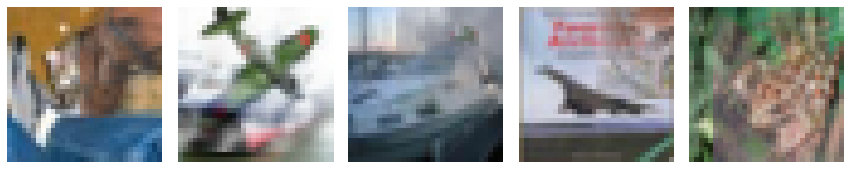

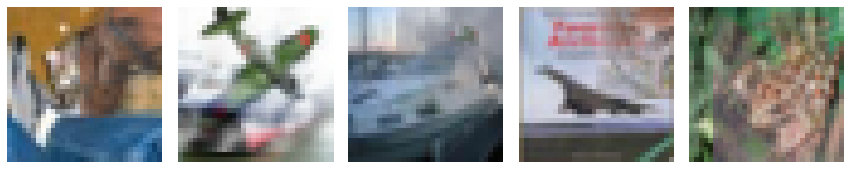

In [25]:
print_fig((mixed_x_1.cpu() * std_torch + mean_torch)[:5])
print_fig((mixed_x_2.cpu() * std_torch + mean_torch)[:5])

In [14]:
(mixed_lam_1[0] - mixed_lam_2[0]).abs().max()

tensor(1.1921e-07, device='cuda:0')

In [57]:
index = torch.tensor([[1,1]])

In [58]:
torch.zeros(4, 4, dtype=src.dtype).scatter_(1, index, src)

tensor([[0, 2, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

In [18]:
t = torch.zeros([2,2,32,32])
t[:,0].shape

torch.Size([2, 32, 32])

In [17]:
t[:,1].shape

torch.Size([2, 32])

In [19]:
input_sp.shape

torch.Size([100, 3, 32, 32])

In [20]:
padded_holder = torch.zeros([100,3,96,96]).scatter(,input_sp)

In [162]:
theta[:,0,2].shape

torch.Size([100])

input shape:  torch.Size([100, 3, 32, 32])
padded_input shape:  torch.Size([100, 3, 96, 96])
tensor([[ 1.0000,  0.0000, -0.6667],
        [ 0.0000,  1.0000, -0.6667]])


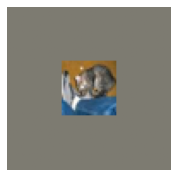

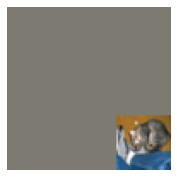

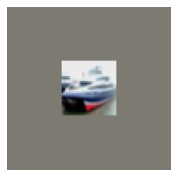

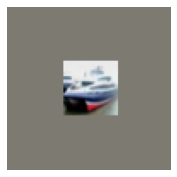

In [88]:
print("input shape: ",input_sp.shape)
padded_input = pad_zeros(input_sp, 32, 32, 32, 32)
print("padded_input shape: ",padded_input.shape)
theta = torch.eye(2,3).repeat(100,1,1)
theta[0,0,2] = -2*32/96
theta[0,1,2] = -2*32/96

theta[1,0,2] = -2*1/96
theta[1,1,2] = -2*0.5/96

print(theta[0])
size = torch.Size((100,3,96,96))
grid = torch.nn.functional.affine_grid(theta, size, align_corners=True)
output_img = torch.nn.functional.grid_sample(padded_input,
                                             grid,
                                             mode='nearest',
                                             padding_mode ='zeros',
                                             align_corners=True)

print_fig((padded_input[0] * std_torch + mean_torch))
print_fig((output_img[0] * std_torch + mean_torch))

print_fig((padded_input[1] * std_torch + mean_torch))
print_fig((output_img[1] * std_torch + mean_torch))

In [151]:
padded_input[0]-output_img[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [90]:
torch.eye(2,3)

tensor([[1., 0., 0.],
        [0., 1., 0.]])

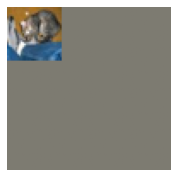

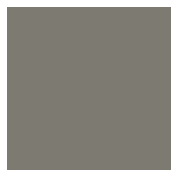